In [1]:
import numpy as np
import pandas as pd
import fine_tuning
import sys
sys.path.append("..")
import utils.pos_utils as pos_utils

### Training language and general setup

In [2]:
data_path = "../data/ud/"
short_model_name = "xlm-roberta"
experiment = "acl"
task = "pos"
checkpoints_path = "E:/TFM_CCIL/checkpoints/"
        
training_lang = fine_tuning.get_global_training_state(data_path, short_model_name, experiment, checkpoints_path)
trainer = fine_tuning.Trainer(training_lang, data_path, task, short_model_name)

Training language:   Spanish 

Already trained:     Slovak  Chinese  Vietnamese  Finnish  Basque  Korean  Japanese  Turkish  Arabic  Hebrew

Not yet trained:     Norwegian  Greek  Maltese

Cannot train:        German  Thai  Cantonese  Indonesian  Algerian  Amharic



### Model setup

In [3]:
# Model parameters
max_length = 256
batch_size = 8
learning_rate = 2e-5
epochs = 20
tagset = pos_utils.get_ud_tags()
num_labels = len(tagset)

# Model creation
trainer.build_model(max_length, batch_size, learning_rate, epochs, num_labels, tagset=tagset, eval_batch_size=64)

# Checkpoint for best model weights
trainer.setup_checkpoint(checkpoints_path)

Some weights of the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaForTokenClassification: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFXLMRobertaForTokenClassification were not initialized from the model checkpoint at jplu/tf-xlm-roberta-base and are newly initialized: ['classifier', 'dropout_38']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully built tf-xlm-roberta-base
Checkpoint file: E:/TFM_CCIL/checkpoints/es/tf-xlm-roberta-base_pos_checkpoint.hdf5
Temp weights file: E:/TFM_CCIL/checkpoints/es/tf-xlm-roberta-base_temp.hdf5


### Data preparation

In [4]:
trainer.prepare_data()

print("Train examples:", len(trainer.train_data))

# Print an example sentence for sanity
example_batch = trainer.train_dataset.as_numpy_iterator().next()
for token, label in zip(example_batch[0]["input_ids"][0], example_batch[1][0]):
    if not token:
        break
    elif token == example_batch[0]["input_ids"][0][10]:
        print("...")
        break
    print("{:<25}{:<20}".format(trainer.tokenizer.decode(int(token)), tagset[label]))


Train examples: 14305
A                        ADP                 
la                       DET                 
inaugura                 NOUN                
ción                     NOUN                
del                      ADP                 
SI                       PROPN               
TC                       PROPN               
han                      AUX                 
asist                    VERB                
ido                      VERB                
...


### Training

Elapsed:                 8:16:17                  
Estimated remaining:     6:53:34                  



History:

Best dev score so far: 0.988

Epoch               Loss                Train score         Dev score           
0                   0.099               0.973               0.972               
1                   0.017               0.978               0.975               
2                   0.011               0.988               0.984               
3                   0.007               0.992               0.986               
4                   0.005               0.994               0.986               
5                   0.005               0.995               0.987               
6                   0.004               0.996               0.988               
7                   0.003               0.997               0.987               
8                   0.003               0.997               0.986               
9                   0.002               0.998               0.987               
10                  0.003               0.996               0.985   

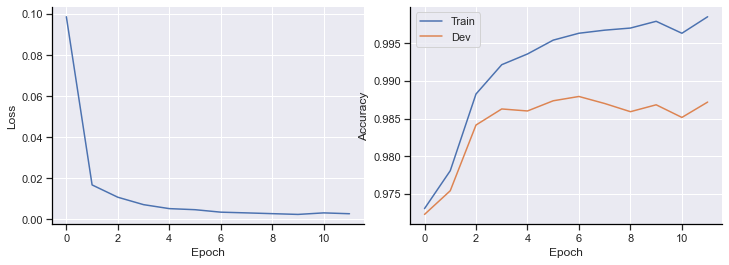


Epoch 12
 715/1789 [==========>...................] - ETA: 10:43 - loss: 0.0022

In [ ]:
trainer.setup_training()
trainer.train()